# Backtesting a Trading Strategy with SysTrader

## Contents

* [Running a Backtest](#backtest)
    * [Backtesting on one instrument](#backtesting-on-one-trading-instrument)
    * [Inspecting backtest results](#inspecting-backtest-results)
    * [Backtesting on multiple instruments](#backtesting-on-multiple-trading-instruments)
* [Analysing Strategy Performance with Pyfolio](#analysing-backtest-results-with-pyfolio)

## Running a Backtest <a id="backtest"></a>
The following four components are required to conduct a backtest with MarginTrader:

1. Data Handler: for managing how data flows through the system.
2. Broker: for simulating order execution and position handling on a brokage account.
3. Strategy: for writing the strategy logic and interacting with the rest of the system.
4. Trader: for running the system.

MarginTrader provides three backtest data handlers: CSV, Pandas, and Yahoo data handlers. In this example, we'll use the CSV data handler.

We'll backtest a momentum strategy that buy when the current bar's close price exceeds the previous bar's close price and sell when the opposite occurs. The strategy will be tested using one-year historical data for Apple and Microsoft stocks from March 7, 2023 to March 7, 2024.

In [1]:
from systrader.broker import SimBroker
from systrader.datahandler import HistoricCSVDataHandler
from systrader.strategy import Strategy
from systrader.trader import Trader
from systrader.constants import OrderSide

### Backtesting on one trading instrument
To write a strategy component for the backtesting, subclass the `Strategy` class and override the `on_market` method. The strategy and order creation logic should be defined or called in the `on_market` method, which is called whenever new market data is received by the system.

In [2]:
DATA_PATH = "../data"   # Path to CSV file
SYMBOLS = ["AAPL"]      # Name(s) of CSV files (AAPL.csv)

In [3]:
class Momentum(Strategy):
    prev_price = None

    def on_market(self):
        latest_bar = self.data_handler.get_latest_bars(self.symbols[0])[0]
        curr_price = latest_bar.close
        position = self.broker.get_position(self.symbols[0])
        signal = self.calculate_signal(curr_price)
        self.prev_price = curr_price

        if signal:
            if position:
               return
            else:
                if signal == OrderSide.BUY:
                    sl = latest_bar.low * 0.97
                    tp = 2 * (latest_bar.close - sl) + curr_price
                    self.broker.buy(symbol=self.symbols[0], sl=sl, tp=tp)
                else:
                    sl = latest_bar.high * 1.03
                    tp = latest_bar.close - (sl - curr_price) * 2
                    self.broker.sell(symbol=self.symbols[0], sl=sl, tp=tp)

    def calculate_signal(self, price):
        if self.prev_price:
            if price > self.prev_price:
                return OrderSide.BUY
            return OrderSide.SELL
        return None

In [4]:
# Create the trading components
data_handler = HistoricCSVDataHandler(csv_dir=DATA_PATH, symbols=SYMBOLS)
sim_broker = SimBroker(
    balance=100_000,
    leverage=1,
    commission=3.0, # Transaction cost for opening and closing trades.
    acct_mode="hedging",
    trading_price="close",  # Execute trades at current close price
)
strategy = Momentum(
    symbols=SYMBOLS,  # Symbols to trade.
)
trader = Trader(data_handler=data_handler, broker=sim_broker, strategy=strategy)

# Run the strategy
trader.run()

Starting backtest
Finished running backtest


### Inspecting Backtest Results
After the backtest simulation is completed, an `account_history` dictionary gets added to the Trader instance. The `account_history` has the following keys:

* balance_equity: a dataframe containing historical account balances and equity values.
* positions: a dataframe containing historical positions.
* orders: a data frame containing historical orders.

We can use this dataframes to inspect if the expected trades were executed or not.

In [5]:
# Checking the first daily bars
trader.data_handler.latest_symbol_data["AAPL"][:5]

[AAPL(timestamp=Timestamp('2023-03-07 00:00:00'), open=153.699997, high=154.029999, low=151.130005, close=151.600006, volume=56182000),
 AAPL(timestamp=Timestamp('2023-03-08 00:00:00'), open=152.809998, high=153.470001, low=151.830002, close=152.869995, volume=47204800),
 AAPL(timestamp=Timestamp('2023-03-09 00:00:00'), open=153.559998, high=154.539993, low=150.229996, close=150.589996, volume=53833600),
 AAPL(timestamp=Timestamp('2023-03-10 00:00:00'), open=150.210007, high=150.940002, low=147.610001, close=148.5, volume=68572400),
 AAPL(timestamp=Timestamp('2023-03-13 00:00:00'), open=147.809998, high=153.139999, low=147.699997, close=150.470001, volume=84457100)]

In [6]:
trader.data_handler.latest_symbol_data["AAPL"][-5:]

[AAPL(timestamp=Timestamp('2024-03-01 00:00:00'), open=179.550003, high=180.529999, low=177.380005, close=179.660004, volume=73488000),
 AAPL(timestamp=Timestamp('2024-03-04 00:00:00'), open=176.149994, high=176.899994, low=173.789993, close=175.100006, volume=81510100),
 AAPL(timestamp=Timestamp('2024-03-05 00:00:00'), open=170.759995, high=172.039993, low=169.619995, close=170.119995, volume=95132400),
 AAPL(timestamp=Timestamp('2024-03-06 00:00:00'), open=171.059998, high=171.240005, low=168.679993, close=169.119995, volume=68587700),
 AAPL(timestamp=Timestamp('2024-03-07 00:00:00'), open=169.149994, high=170.729996, low=168.490005, close=169.0, volume=69861226)]

In [7]:
trader.account_history["positions"]

,symbol,side,units,open_price,close_price,commission,pnl,open_time,close_time,id
0,AAPL,buy,100,152.869995,164.059781,6.0,1112.978612,2023-03-08,2023-03-31,1
1,AAPL,buy,100,164.899994,180.594574,6.0,1563.458024,2023-03-31,2023-06-02,2
2,AAPL,buy,100,180.949997,195.085601,6.0,1407.560370,2023-06-02,2023-07-19,3
3,AAPL,buy,100,195.100006,186.870494,6.0,-828.951182,2023-07-19,2023-08-04,4
4,AAPL,sell,100,181.990005,193.001405,6.0,-1107.140015,2023-08-04,2023-12-05,5
5,AAPL,buy,100,193.419998,184.474593,6.0,-900.540479,2023-12-05,2024-01-02,6
6,AAPL,sell,100,185.639999,194.093202,6.0,-851.320306,2024-01-02,2024-01-22,7
7,AAPL,buy,100,193.889999,186.492195,6.0,-745.780385,2024-01-22,2024-01-31,8
8,AAPL,sell,100,184.399994,169.000000,6.0,1533.999400,2024-01-31,2024-03-07,9


In [8]:
trader.account_history["orders"]

,timestamp,symbol,order_type,units,side,price,sl,tp,status,order_id,position_id,request
0,2023-03-08,AAPL,mkt,100,buy,NaN,147.275102,164.059781,executed,1,1,open
1,2023-03-08,AAPL,stp,100,sell,147.275102,NaN,NaN,canceled,1,1,close
2,2023-03-08,AAPL,lmt,100,sell,164.059781,NaN,NaN,executed,1,1,close
3,2023-03-31,AAPL,mkt,100,buy,NaN,157.052704,180.594574,executed,2,2,open
4,2023-03-31,AAPL,stp,100,sell,157.052704,NaN,NaN,canceled,2,2,close
5,2023-03-31,AAPL,lmt,100,sell,180.594574,NaN,NaN,executed,2,2,close
6,2023-06-02,AAPL,mkt,100,buy,NaN,173.882195,195.085601,executed,3,3,open
7,2023-06-02,AAPL,stp,100,sell,173.882195,NaN,NaN,canceled,3,3,close
8,2023-06-02,AAPL,lmt,100,sell,195.085601,NaN,NaN,executed,3,3,close
9,2023-07-19,AAPL,mkt,100,buy,NaN,186.870494,211.559030,executed,4,4,open


### Backtesting on multiple trading instruments
To use a strategy for two or more assets, loop through all the available symbols in the strategy instance and apply the trading logic on each of them.

In [9]:
class Momentum(Strategy):
    def __init__(self, symbols):
        super().__init__(symbols)
        self.prev_price = {symbol: None for symbol in self.symbols}

    def on_market(self):
        for symbol in self.symbols:
            self.trade(symbol)

    def trade(self, symbol):
        latest_bar = self.data_handler.get_latest_bars(symbol)[0]
        curr_price = latest_bar.close
        position = self.broker.get_position(symbol)
        signal = self.calculate_signal(symbol, curr_price)
        self.prev_price[symbol] = curr_price

        if signal:
            if position:
                return
            else:
                if signal == OrderSide.BUY:
                    sl = latest_bar.low * 0.97
                    tp = 2 * (latest_bar.close - sl) + curr_price
                    self.broker.buy(symbol=symbol, sl=sl, tp=tp)
                else:
                    sl = latest_bar.high * 1.03
                    tp = latest_bar.close - (sl - curr_price) * 2
                    self.broker.sell(symbol=symbol, sl=sl, tp=tp)

    def calculate_signal(self, symbol, curr_price):
        prev_price = self.prev_price[symbol]
        if prev_price:
            if curr_price > prev_price:
                return OrderSide.BUY
            return OrderSide.SELL
        return None

In [10]:
SYMBOLS = ["AAPL", "MSFT"]
data_handler = HistoricCSVDataHandler(csv_dir=DATA_PATH, symbols=SYMBOLS)
sim_broker = SimBroker(
    balance=100_000,
    leverage=1,
    commission=3.0,
    acct_mode="hedging",
    trading_price="close",
)
strategy = Momentum(symbols=SYMBOLS)
trader = Trader(data_handler=data_handler, broker=sim_broker, strategy=strategy)
trader.run()

Starting backtest
Finished running backtest


In [11]:
display(
    trader.data_handler.latest_symbol_data["AAPL"][:5],
    trader.data_handler.latest_symbol_data["MSFT"][:5],
    trader.account_history["positions"].head(10),
    trader.account_history["orders"].head(10)
)

[AAPL(timestamp=Timestamp('2023-03-07 00:00:00'), open=153.699997, high=154.029999, low=151.130005, close=151.600006, volume=56182000),
 AAPL(timestamp=Timestamp('2023-03-08 00:00:00'), open=152.809998, high=153.470001, low=151.830002, close=152.869995, volume=47204800),
 AAPL(timestamp=Timestamp('2023-03-09 00:00:00'), open=153.559998, high=154.539993, low=150.229996, close=150.589996, volume=53833600),
 AAPL(timestamp=Timestamp('2023-03-10 00:00:00'), open=150.210007, high=150.940002, low=147.610001, close=148.5, volume=68572400),
 AAPL(timestamp=Timestamp('2023-03-13 00:00:00'), open=147.809998, high=153.139999, low=147.699997, close=150.470001, volume=84457100)]

[MSFT(timestamp=Timestamp('2023-03-07 00:00:00'), open=256.299988, high=257.690002, low=253.389999, close=254.149994, volume=21473200),
 MSFT(timestamp=Timestamp('2023-03-08 00:00:00'), open=254.039993, high=254.539993, low=250.809998, close=253.699997, volume=17340200),
 MSFT(timestamp=Timestamp('2023-03-09 00:00:00'), open=255.820007, high=259.559998, low=251.580002, close=252.320007, volume=26653400),
 MSFT(timestamp=Timestamp('2023-03-10 00:00:00'), open=251.080002, high=252.789993, low=247.600006, close=248.589996, volume=28333900),
 MSFT(timestamp=Timestamp('2023-03-13 00:00:00'), open=247.399994, high=257.910004, low=245.729996, close=253.919998, volume=33339700)]

,symbol,side,units,open_price,close_price,commission,pnl,open_time,close_time,id
0,MSFT,sell,100,253.699997,262.176193,6.0,-853.619579,2023-03-08,2023-03-15,2
1,AAPL,buy,100,152.869995,164.059781,6.0,1112.978612,2023-03-08,2023-03-31,1
2,MSFT,buy,100,265.440002,293.452623,6.0,2795.262146,2023-03-15,2023-04-26,3
3,MSFT,buy,100,295.369995,318.213764,6.0,2278.376866,2023-04-26,2023-05-18,5
4,AAPL,buy,100,164.899994,180.594574,6.0,1563.458024,2023-03-31,2023-06-02,4
5,MSFT,buy,100,318.519989,346.943165,6.0,2836.317606,2023-05-18,2023-06-15,6
6,MSFT,buy,100,348.100006,327.084012,6.0,-2107.599436,2023-06-15,2023-07-11,8
7,MSFT,buy,100,332.470001,363.030003,6.0,3050.000200,2023-07-11,2023-07-18,9
8,AAPL,buy,100,180.949997,195.085601,6.0,1407.560370,2023-06-02,2023-07-19,7
9,MSFT,buy,100,359.489990,331.904913,6.0,-2764.507739,2023-07-18,2023-07-27,10


,timestamp,symbol,order_type,units,side,price,sl,tp,status,order_id,position_id,request
0,2023-03-08,AAPL,mkt,100,buy,NaN,147.275102,164.059781,executed,1,1,open
1,2023-03-08,AAPL,stp,100,sell,147.275102,NaN,NaN,canceled,1,1,close
2,2023-03-08,AAPL,lmt,100,sell,164.059781,NaN,NaN,executed,1,1,close
3,2023-03-08,MSFT,mkt,100,sell,NaN,262.176193,236.747605,executed,2,2,open
4,2023-03-08,MSFT,stp,100,buy,262.176193,NaN,NaN,executed,2,2,close
5,2023-03-08,MSFT,lmt,100,buy,236.747605,NaN,NaN,canceled,2,2,close
6,2023-03-15,MSFT,mkt,100,buy,NaN,251.433691,293.452623,executed,3,3,open
7,2023-03-15,MSFT,stp,100,sell,251.433691,NaN,NaN,canceled,3,3,close
8,2023-03-15,MSFT,lmt,100,sell,293.452623,NaN,NaN,executed,3,3,close
9,2023-03-31,AAPL,mkt,100,buy,NaN,157.052704,180.594574,executed,4,4,open


## Analysing backtest results with Pyfolio
Pyfolio is a portfolio analysis tool for generating various statistical metrics from historical data of financial assets returns and trades.

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pyfolio as pf
from systrader.performance.utils import get_pyfolio_roundtrips

In [14]:
rts = get_pyfolio_roundtrips(trader.account_history)
equity_rets = trader.account_history["balance_equity"]["equity"].pct_change().fillna(0)

In [15]:
pf.round_trips.print_round_trip_stats(rts)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,22.00,7.00,15.00
Percent profitable,0.50,0.29,0.60
Winning round_trips,11.00,2.00,9.00
Losing round_trips,11.00,5.00,6.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$8011.03,$-4186.54,$12197.57
Gross profit,$23448.21,$2106.00,$21342.21
Gross loss,$-15437.18,$-6292.54,$-9144.65
Profit factor,$1.52,$0.33,$2.33
Avg. trade net profit,$364.14,$-598.08,$813.17
Avg. winning trade,$2131.66,$1053.00,$2371.36
Avg. losing trade,$-1403.38,$-1258.51,$-1524.11
Ratio Avg. Win:Avg. Loss,$1.52,$0.84,$1.56
Largest winning trade,$3171.98,$1534.00,$3171.98
Largest losing trade,$-2764.51,$-2090.99,$-2764.51


Duration stats,All trades,Short trades,Long trades
Avg duration,33 days 04:21:49.090909091,43 days,28 days 14:24:00
Median duration,24 days 12:00:00,20 days,26 days 00:00:00
Longest duration,123 days 00:00:00,123 days,69 days 00:00:00
Shortest duration,3 days 00:00:00,3 days,7 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.37%,-0.56%,0.80%
Avg returns winning,2.03%,0.99%,2.26%
Avg returns losing,-1.30%,-1.18%,-1.39%
Median returns all round_trips,-0.08%,-0.85%,1.27%
Median returns winning,2.21%,0.99%,2.65%
Median returns losing,-1.04%,-1.04%,-1.25%
Largest winning trade,3.04%,1.44%,3.04%
Largest losing trade,-2.47%,-1.93%,-2.47%


Symbol stats,AAPL,MSFT
Avg returns all round_trips,0.13%,0.53%
Avg returns winning,1.33%,2.43%
Avg returns losing,-0.83%,-1.69%
Median returns all round_trips,-0.70%,0.53%
Median returns winning,1.36%,2.79%
Median returns losing,-0.79%,-1.78%
Largest winning trade,1.48%,3.04%
Largest losing trade,-1.04%,-2.47%


Start date,2023-03-07
End date,2024-03-07
Total months,12
,Backtest
Annual return,7.978%
Cumulative returns,8.011%
Annual volatility,8.433%
Sharpe ratio,0.95
Calmar ratio,1.55
Stability,0.27
Max drawdown,-5.141%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.14,2023-07-18,2024-01-02,NaT,NaN
1,1.84,2023-06-15,2023-06-26,2023-06-30,12
2,1.76,2023-06-30,2023-07-11,2023-07-18,13
3,1.66,2023-04-06,2023-04-25,2023-04-26,15
4,1.40,2023-06-02,2023-06-07,2023-06-13,8


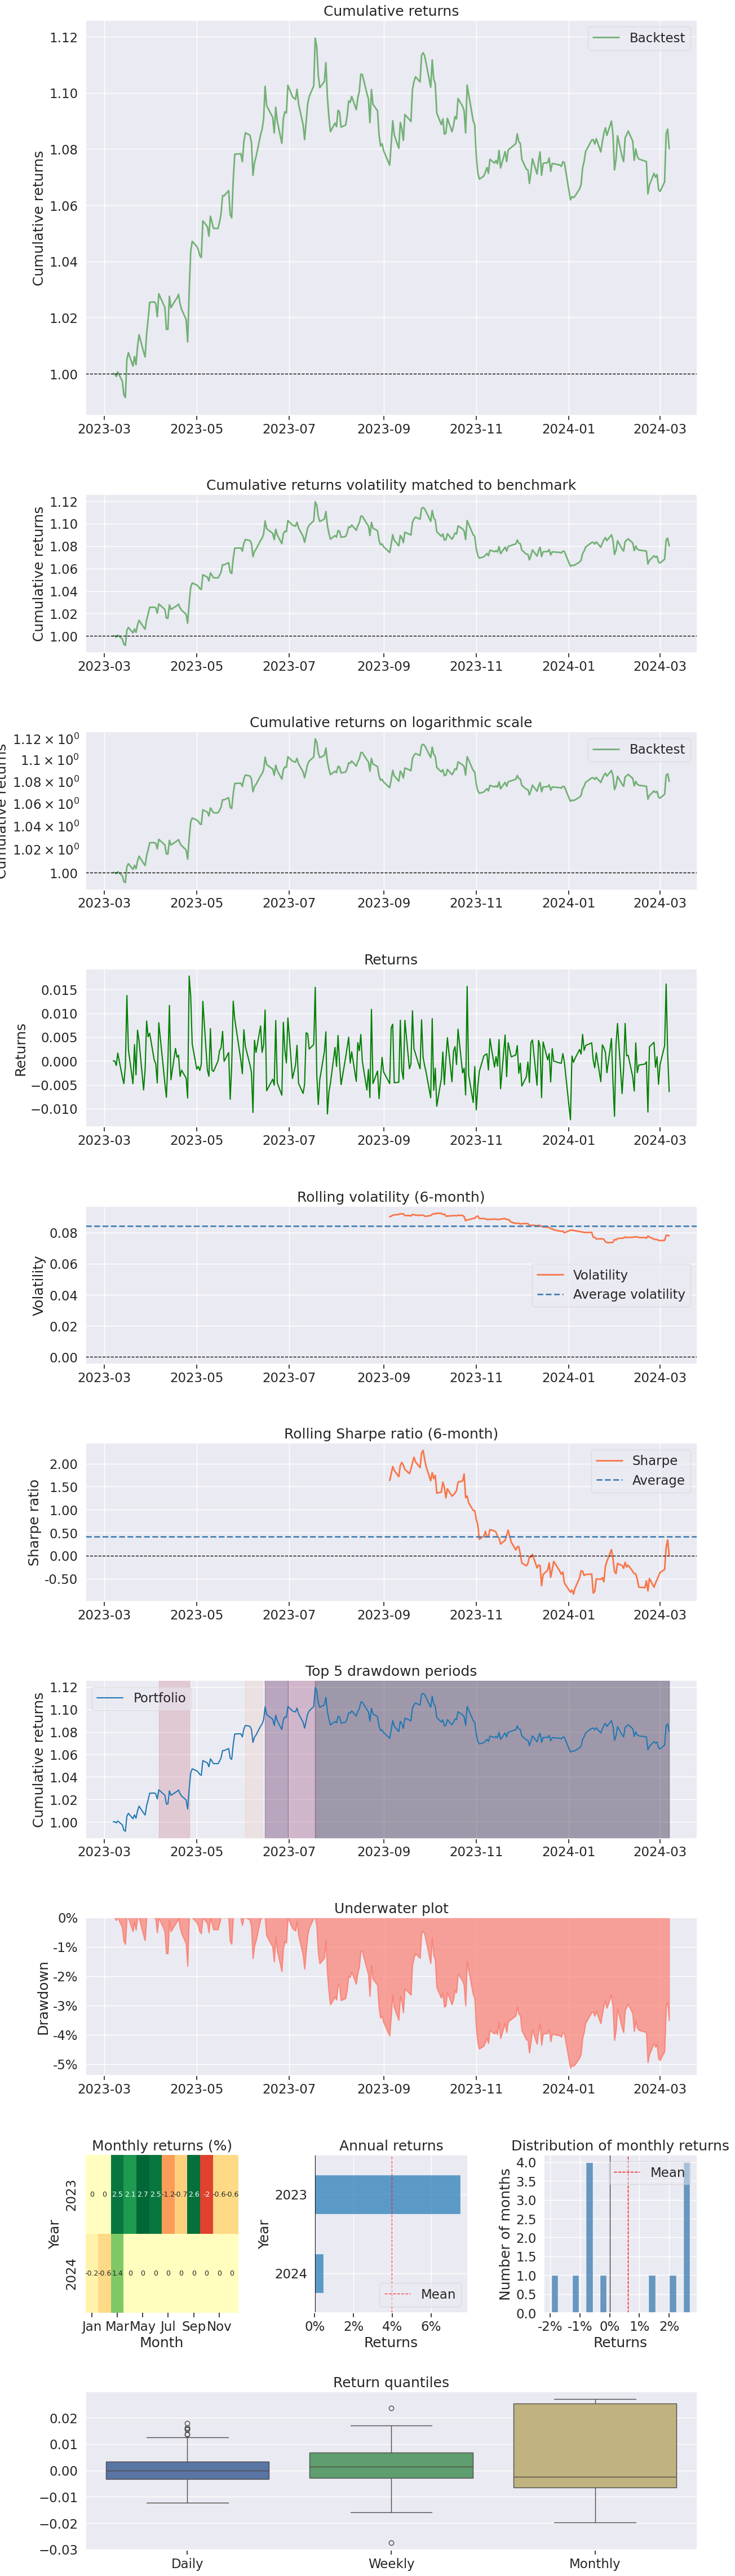

In [16]:
pf.create_returns_tear_sheet(equity_rets)

## References

* https://www.quantstart.com/articles/Event-Driven-Backtesting-with-Python-Part-I/
* https://github.com/stefan-jansen/pyfolio-reloaded